# E-commerce Analysis 🪑

---



## Data collection

---



In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr, spearmanr, kendalltau

In [ ]:
auth.authenticate_user()
client = bigquery.Client(project="data-analytics-mate")

In [ ]:
query = """
        SELECT
            s.date AS order_date,
            s.ga_session_id,
            sp.continent,
            sp.country,
            sp.device,
            sp.browser,
            sp.mobile_model_name,
            sp.operating_system,
            sp.language,
            sp.name as channel_info,
            sp.channel AS traffic_channel,
            a.is_verified AS email_verified,
            a.is_unsubscribed AS unsubscribed,
            a.id as account_id,
            p.category AS product_category,
            p.name as product_name,
            p.price as product_price,
            p.short_description
        FROM DA.session s
        LEFT JOIN DA.order o USING(ga_session_id)
        LEFT JOIN DA.product p USING(item_id)
        LEFT JOIN DA.session_params sp USING (ga_session_id)
        LEFT JOIN DA.account_session acs USING (ga_session_id)
        LEFT JOIN DA.account a ON acs.account_id = a.id
        """

In [ ]:
query_job = client.query(query)
results = query_job.result()

In [ ]:
df = results.to_dataframe()

Data was collected from Google BigQuery using Python in Google Colab. A SQL query joined multiple tables to obtain session, user, account, and product info. The results were loaded into a Pandas DataFrame for further analysis.



## Data cleaning & preparation

---



In [ ]:
df.shape

(349545, 18)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   channel_info       349545 non-null  object 
 10  traffic_channel    349545 non-null  object 
 11  email_verified     27945 non-null   Int64  
 12  unsubscribed       27945 non-null   Int64  
 13  account_id         27945 non-null   Int64  
 14  product_category   33538 non-null   object 
 15  product_name       33538 non-null   object 
 16  pr

In [ ]:
df.describe()

,ga_session_id,email_verified,unsubscribed,account_id,product_price
count,349545.0,27945.0,27945.0,27945.0,33538.000000
mean,4992250296.631739,0.71698,0.16944,659005.065557,953.298679
std,2887450949.537772,0.450474,0.375147,13216.529465,1317.001775
min,1205.0,0.0,0.0,636133.0,3.000000
25%,2493646855.0,0.0,0.0,647576.0,170.000000
50%,4988476074.0,1.0,0.0,658952.0,445.000000
75%,7491286508.0,1.0,0.0,670414.0,1195.000000
max,9999997129.0,1.0,1.0,681962.0,9585.000000


In [ ]:
print((df.isnull().mean() * 100).round(2).map(lambda x: f'{x}%'))

order_date             0.0%
ga_session_id          0.0%
continent              0.0%
country                0.0%
device                 0.0%
browser                0.0%
mobile_model_name      0.0%
operating_system       0.0%
language             32.69%
channel_info           0.0%
traffic_channel        0.0%
email_verified       92.01%
unsubscribed         92.01%
account_id           92.01%
product_category     90.41%
product_name         90.41%
product_price        90.41%
short_description    90.41%
dtype: object


In [ ]:
df['continent'].value_counts()

,count
continent,
Americas,193179
Asia,83113
Europe,65135
Oceania,3703
Africa,3620
(not set),795


In [ ]:
df['continent'] = df['continent'].replace('(not set)', 'Unspecified')
df['continent'].value_counts().loc['Unspecified']

np.int64(795)

In [ ]:
df['country'].unique()

array(['United States', 'United Kingdom', 'Norway', 'Nigeria', 'China',
       'Germany', '(not set)', 'Ecuador', 'Japan', 'Canada', 'Italy',
       'Indonesia', 'South Korea', 'Belgium', 'Pakistan',
       'United Arab Emirates', 'Uruguay', 'Israel', 'Czechia', 'India',
       'Taiwan', 'Georgia', 'Portugal', 'Thailand', 'Bangladesh',
       'Turkey', 'Vietnam', 'Philippines', 'France', 'Switzerland',
       'Greece', 'Sweden', 'Malaysia', 'Slovenia', 'Argentina',
       'Singapore', 'Spain', 'Brazil', 'Denmark', 'Dominican Republic',
       'Australia', 'Mexico', 'Colombia', 'Netherlands', 'Poland',
       'Lithuania', 'Ukraine', 'Chile', 'Oman', 'Ireland', 'Kuwait',
       'New Zealand', 'Peru', 'Sri Lanka', 'Tunisia', 'Lebanon',
       'Puerto Rico', 'Saudi Arabia', 'Egypt', 'Slovakia',
       'Bosnia & Herzegovina', 'El Salvador', 'Bahrain', 'Jordan',
       'Bolivia', 'Austria', 'Albania', 'Hong Kong', 'Paraguay', 'Iraq',
       'Panama', 'Guatemala', 'Kazakhstan', 'Nepal', 'Cost

In [ ]:
df['country'] = df['country'].replace('(not set)', 'Unspecified')
df['country'].value_counts().loc['Unspecified']

np.int64(2808)

In [ ]:
df['device'].value_counts()

,count
device,
desktop,204429
mobile,137267
tablet,7849


In [ ]:
df['device'] = df['device'].str.capitalize()
df['device'].value_counts()

,count
device,
Desktop,204429
Mobile,137267
Tablet,7849


In [ ]:
df['browser'].value_counts()

,count
browser,
Chrome,238460
Safari,83254
<Other>,8930
Edge,8023
Firefox,6433
Android Webview,4445


In [ ]:
df['browser'] = df['browser'].replace('<Other>', 'Unspecified')
df['browser'].value_counts().loc['Unspecified']

np.int64(8930)

In [ ]:
df['mobile_model_name'].value_counts()

,count
mobile_model_name,
Chrome,97254
iPhone,71326
Safari,70891
<Other>,70839
ChromeBook,19084
Edge,7907
iPad,5090
Firefox,4874
Pixel 4 XL,1246


In [ ]:
df['mobile_model_name'] = df['mobile_model_name'].replace('<Other>', 'Unspecified')
df['mobile_model_name'].value_counts().loc['Unspecified']

np.int64(70839)

In [ ]:
df['operating_system'].value_counts()

,count
operating_system,
Web,203909
Windows,40937
iOS,40102
Android,29808
Macintosh,26116
<Other>,8673


In [ ]:
df['operating_system'] = df['operating_system'].replace('<Other>', 'Unspecified')
df['operating_system'].value_counts().loc['Unspecified']

np.int64(8673)

In [ ]:
df['language'].unique()

array(['zh', 'en-us', 'es-es', None, 'en-gb', 'en-ca', 'fr', 'ko', 'en',
       'de'], dtype=object)

In [ ]:
language_map = {
    'zh': 'Chinese',
    'en-us': 'English (US)',
    'es-es': 'Spanish',
    'en-gb': 'English (UK)',
    'en-ca': 'English (Canada)',
    'fr': 'French',
    'ko': 'Korean',
    'en': 'English',
    'de': 'German'
}

In [ ]:
df['language'] = df['language'].map(language_map)

In [ ]:
df['language'].value_counts()

,count
language,
English (US),159893
English (UK),24774
Chinese,12222
English,11518
English (Canada),9332
Spanish,5760
French,5652
German,3387
Korean,2741


In [ ]:
df.groupby('language')['account_id'].count().head(10)

,account_id
language,
Chinese,958
English,887
English (Canada),783
English (UK),1978
English (US),12770
French,462
German,247
Korean,217
Spanish,442


In [ ]:
df['channel_info'].unique()

array(['<Other>', '(organic)', '(direct)', '(data deleted)', '(referral)'],
      dtype=object)

In [ ]:
channel_map = {
    '(organic)': 'Organic',
    '(direct)': 'Direct',
    '<Other>': 'Unspecified',
    '(referral)': 'Referral',
    '(data deleted)': 'Data Deleted'
}

In [ ]:
df['channel_info'] = df['channel_info'].map(channel_map)

Languages and traffic channels were mapped to more readable categories.

In [ ]:
df['channel_info'].value_counts()

,count
channel_info,
Organic,119024
Direct,81382
Unspecified,66289
Referral,61436
Data Deleted,21414


In [ ]:
df.groupby('channel_info')['account_id'].count()

,account_id
channel_info,
Data Deleted,1697
Direct,6514
Organic,9659
Referral,4866
Unspecified,5209


In [ ]:
df['traffic_channel'].unique()

array(['Paid Search', 'Organic Search', 'Direct', 'Undefined',
       'Social Search'], dtype=object)

In [ ]:
df['traffic_channel'] = df['traffic_channel'].replace('Undefined', 'Unspecified')
df['traffic_channel'].value_counts()

,count
traffic_channel,
Organic Search,124425
Paid Search,94341
Direct,81382
Social Search,27914
Unspecified,21483


The raw dataset was examined using basic exploratory commands to understand its structure, missing values, and distributions. Missing or undefined categorical values (e.g., (not set), 'Other') were replaced with 'Unspecified' for consistency across features such as continent, country, browser, device, and operating system.

In [ ]:
df.groupby('traffic_channel')['account_id'].count()

,account_id
traffic_channel,
Direct,6514
Organic Search,10035
Paid Search,7467
Social Search,2212
Unspecified,1717


In [ ]:
df['email_verified'].value_counts()

,count
email_verified,
1,20036
0,7909


In [ ]:
df['unsubscribed'].value_counts()

,count
unsubscribed,
0,23210
1,4735


In [ ]:
df['product_category'].unique()

array(['Bookcases & shelving units', 'Tables & desks',
       'Cabinets & cupboards', 'Bar furniture', None, 'Chairs',
       'Sofas & armchairs', 'Outdoor furniture', 'Beds',
       "Children's furniture", 'Chests of drawers & drawer units',
       'Room dividers', 'Sideboards, buffets & console tables',
       'Café furniture', 'Nursery furniture'], dtype=object)

In [ ]:
df['product_category'].value_counts()

,count
product_category,
Bookcases & shelving units,7630
Chairs,5952
Sofas & armchairs,4301
Tables & desks,2941
Beds,2926
Cabinets & cupboards,2318
Outdoor furniture,2229
Children's furniture,1702
Chests of drawers & drawer units,1452


In [ ]:
category_global_map = {
    'Bookcases & shelving units': 'Storage & Organization',
    'Cabinets & cupboards': 'Storage & Organization',
    'Chests of drawers & drawer units': 'Storage & Organization',
    'Sideboards, buffets & console tables': 'Storage & Organization',

    'Tables & desks': 'Tables & Work Surfaces',
    'Café furniture': 'Tables & Work Surfaces',
    'Bar furniture': 'Tables & Work Surfaces',

    'Chairs': 'Seating & Rest',
    'Sofas & armchairs': 'Seating & Rest',
    'Beds': 'Seating & Rest',

    'Room dividers': 'Specialized Furniture',
    'Outdoor furniture': 'Specialized Furniture',
    "Children's furniture": 'Specialized Furniture',
    'Nursery furniture': 'Specialized Furniture',
}

In [ ]:
df['product_category_global'] = df['product_category'].map(category_global_map)
df['product_category_global'].value_counts()

,count
product_category_global,
Seating & Rest,13179
Storage & Organization,11532
Specialized Furniture,4435
Tables & Work Surfaces,4392


Product categories were consolidated into broader global groups to simplify visualization.

In [ ]:
df.groupby('product_category_global')['product_name'].nunique()

,product_name
product_category_global,
Seating & Rest,296
Specialized Furniture,68
Storage & Organization,121
Tables & Work Surfaces,151


In [ ]:
df['product_name'].nunique()

550

In [ ]:
df['product_price'].nunique()

829

In [ ]:
df['short_description'].nunique()

1476

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_date               349545 non-null  dbdate 
 1   ga_session_id            349545 non-null  Int64  
 2   continent                349545 non-null  object 
 3   country                  349545 non-null  object 
 4   device                   349545 non-null  object 
 5   browser                  349545 non-null  object 
 6   mobile_model_name        349545 non-null  object 
 7   operating_system         349545 non-null  object 
 8   language                 235279 non-null  object 
 9   channel_info             349545 non-null  object 
 10  traffic_channel          349545 non-null  object 
 11  email_verified           27945 non-null   Int64  
 12  unsubscribed             27945 non-null   Int64  
 13  account_id               27945 non-null   Int64  
 14  prod

In [ ]:
category = [
    'continent', 'country', 'device', 'browser', 'mobile_model_name',
    'operating_system', 'language', 'channel_info', 'traffic_channel',
    'product_category', 'product_name', 'short_description', 'product_category_global'
]

for col in category:
    df[col] = df[col].astype('category')

In [ ]:
df = df.assign(
    order_date = pd.to_datetime(df['order_date']),
    email_verified = df['email_verified'].astype('boolean'),
    unsubscribed = df['unsubscribed'].astype('boolean'),
    account_id = df['account_id'].astype('Int32'),
    ga_session_id = df['ga_session_id'].astype('uint64'),
    product_price = df['product_price'].astype('float32')
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   order_date               349545 non-null  datetime64[ns]
 1   ga_session_id            349545 non-null  uint64        
 2   continent                349545 non-null  category      
 3   country                  349545 non-null  category      
 4   device                   349545 non-null  category      
 5   browser                  349545 non-null  category      
 6   mobile_model_name        349545 non-null  category      
 7   operating_system         349545 non-null  category      
 8   language                 235279 non-null  category      
 9   channel_info             349545 non-null  category      
 10  traffic_channel          349545 non-null  category      
 11  email_verified           27945 non-null   boolean       
 12  unsubscribed    

Data types were optimized by converting relevant columns to categorical, boolean, datetime, or numeric types, which significantly reduced memory usage. Duplicate entries were checked and the cleaned dataset was saved for subsequent analysis.

In [ ]:
df.to_csv('clean.csv', index=False)

## Exploratory Data Analysis

---



###Key Metrics

In [ ]:
unique_sessions = df["ga_session_id"].nunique()
total_orders = df["product_price"].count()
total_accounts = df["account_id"].nunique()

min_price = df["product_price"].min()
max_price = df["product_price"].max()

min_date = df["order_date"].min()
max_date = df["order_date"].max()

conversion_rate = total_orders / unique_sessions * 100
average_order_value = df['product_price'].mean()
median_order_value = df['product_price'].median()
total_revenue = df['product_price'].sum()

email_verified_rate = df['email_verified'].dropna().mean() * 100
unsubscribe_rate = df.loc[df['email_verified'].notna(), 'unsubscribed'].mean() * 100

print(f"From {min_date:%d-%m-%Y} to {max_date:%d-%m-%Y}\n")

print(f"Unique sessions: {unique_sessions:,}")
print(f"Total orders: {total_orders:,}")
print(f"Conversion rate (orders per session): {conversion_rate:.2f}%\n")

print(f"Total revenue: ${total_revenue:,.0f}")
print(f"Average order value: ${average_order_value:,.2f}")
print(f"Median order value: ${median_order_value:,.2f}")
print(f"Product price range: ${min_price:,.2f} to ${max_price:,.2f}\n")

print(f"Unique accounts: {total_accounts:,}")
print(f"Email verified rate: {email_verified_rate:.2f}%")
print(f"Unsubscribe rate among verified emails: {unsubscribe_rate:.2f}%")

From 01-11-2020 to 31-01-2021

Unique sessions: 349,545
Total orders: 33,538
Conversion rate (orders per session): 9.59%

Total revenue: $31,971,734
Average order value: $953.30
Median order value: $445.00
Product price range: $3.00 to $9,585.00

Unique accounts: 27,945
Email verified rate: 71.70%
Unsubscribe rate among verified emails: 16.94%


The analysis covers the period from 01-11-2020 to 31-01-2021. During this time, there were 349,545 unique sessions and 33,538 total orders, resulting in a conversion rate of 9.59% (orders per session).

The total revenue generated was approximately 32 millіon, with an average order value of 953.30 and a median order value of 445. Product prices ranged from 3 to 9,585.

There were 27,945 unique accounts in the dataset. Among these, 71.7% of emails were verified, and the unsubscribe rate among verified email users was 16.94%.

### General Analysis

In [ ]:
df_sales = df[df['product_price'].notnull()]

In [ ]:
top_continents = (
    df_sales.groupby('continent', observed=True)
    .agg(
        total_sales=('product_price', 'sum'),
        order_count=('product_price', 'count')
    )
    .sort_values(by='total_sales', ascending=False)
    .head(3)
)

top_continents

,total_sales,order_count
continent,,
Americas,17665280.0,18553
Asia,7601298.5,7950
Europe,5934624.0,6261


In [ ]:
top_countries = (
    df_sales.groupby('country', observed=True)
    .agg(
        total_sales=('product_price', 'sum'),
        order_count=('product_price', 'count')
    )
    .sort_values(by='total_sales', ascending=False)
    .head(5)
)

top_countries

,total_sales,order_count
country,,
United States,1.394355e+07,14673
India,2.809762e+06,3029
Canada,2.437921e+06,2560
United Kingdom,9.383179e+05,1029
France,7.106928e+05,678


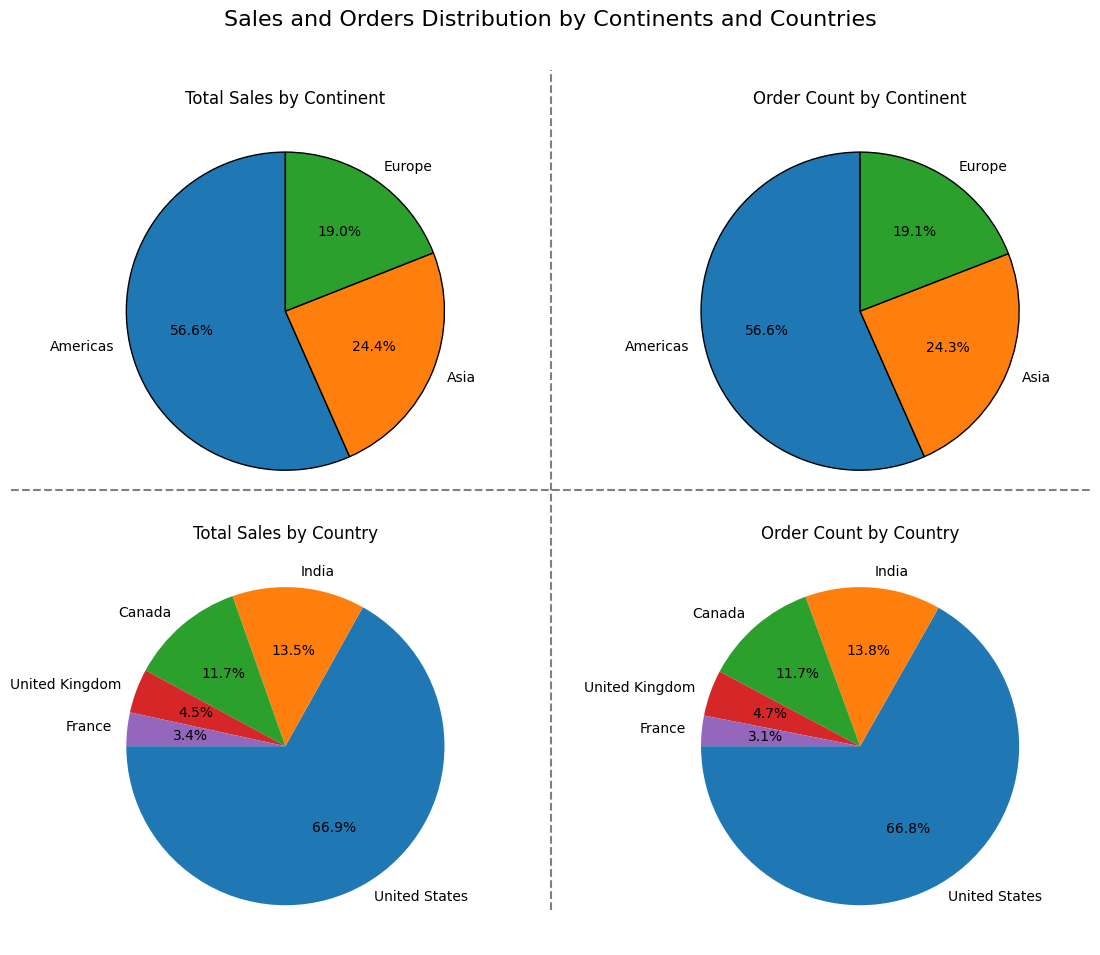

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Sales and Orders Distribution by Continents and Countries', fontsize=16)

axes[0, 0].pie(
    top_continents['total_sales'],
    labels=top_continents.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
axes[0, 0].set_title('Total Sales by Continent')

axes[0, 1].pie(
    top_continents['order_count'],
    labels=top_continents.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
axes[0, 1].set_title('Order Count by Continent')

axes[1, 0].pie(
    top_countries['total_sales'],
    labels=top_countries.index,
    autopct='%1.1f%%',
    startangle=180
)
axes[1, 0].set_title('Total Sales by Country')

axes[1, 1].pie(
    top_countries['order_count'],
    labels=top_countries.index,
    autopct='%1.1f%%',
    startangle=180
)
axes[1, 1].set_title('Order Count by Country')

fig.lines.append(plt.Line2D([0.05, 0.95], [0.5, 0.5], transform=fig.transFigure, color='gray', linestyle='--'))
fig.lines.append(plt.Line2D([0.5, 0.5], [0.08, 0.92], transform=fig.transFigure, color='gray', linestyle='--'))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Top performing regions

The top three continents by sales are Americas, Asia, and Europe. The leading countries are the United States, India, Canada, United Kingdom, and France. These regions generate the highest revenue and order volumes.

In [ ]:
df.describe()

,order_date,ga_session_id,account_id,product_price
count,349545,3.495450e+05,27945.0,33538.000000
mean,2020-12-16 12:42:00.602497536,4.992250e+09,659005.065557,953.298767
min,2020-11-01 00:00:00,1.205000e+03,636133.0,3.000000
25%,2020-11-26 00:00:00,2.493647e+09,647576.0,170.000000
50%,2020-12-15 00:00:00,4.988476e+09,658952.0,445.000000
75%,2021-01-08 00:00:00,7.491287e+09,670414.0,1195.000000
max,2021-01-31 00:00:00,9.999997e+09,681962.0,9585.000000
std,NaN,2.887451e+09,13216.529465,1317.000732


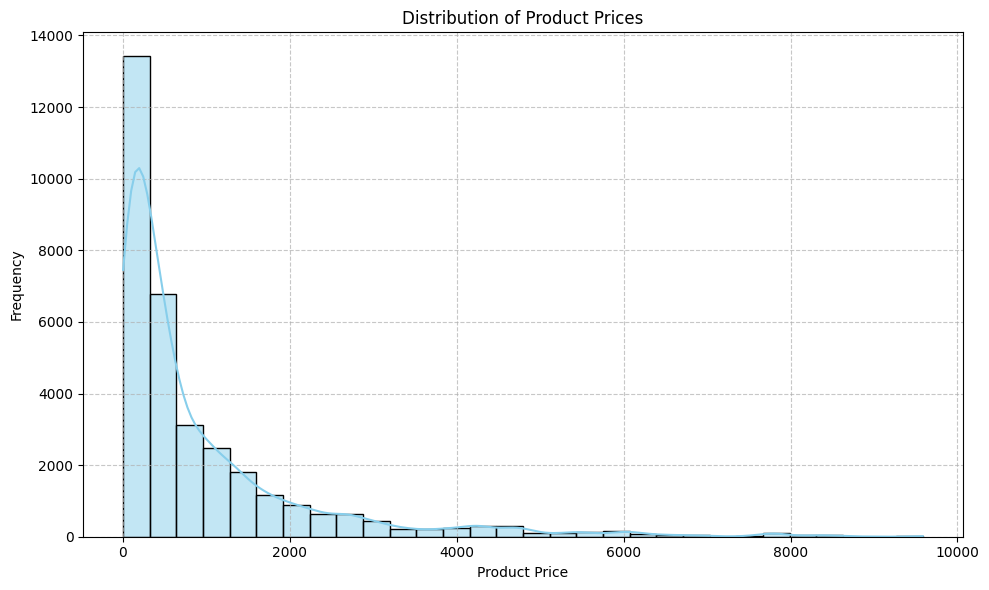

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['product_price'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Product Prices')
plt.xlabel('Product Price')
plt.ylabel('Frequency')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
top_categories_global = (
    df[df['product_price'].notnull()]
    .groupby('product_category', observed=True)
    .agg(
        total_sales=('product_price', 'sum'),
        order_count=('product_price', 'count')
    )
    .sort_values(by='total_sales', ascending=False)
    .head(10)
)

top_categories_global

,total_sales,order_count
product_category,,
Sofas & armchairs,8388254.50,4301
Chairs,6147749.00,5952
Beds,4919725.00,2926
Bookcases & shelving units,3640818.00,7630
Cabinets & cupboards,2336499.50,2318
Outdoor furniture,2142222.25,2229
Tables & desks,1790307.50,2941
Chests of drawers & drawer units,906562.50,1452
Bar furniture,735503.00,1092


Top Product Categories

The top product categories by total sales include Sofas & Armchairs, Chairs, and Beds, generating the highest revenue. Other leading categories are Bookcases & Shelving Units, Cabinets & Cupboards, and Outdoor Furniture. These categories represent the majority of orders and sales value.

In [ ]:
top_country = (
    df[df['product_price'].notnull()]
    .groupby('country', observed=True)
    .agg(
        total_sales=('product_price', 'sum'),
        order_count=('product_price', 'count')
    )
    .sort_values(by='total_sales', ascending=False)
    .head(1)
)

top_country

,total_sales,order_count
country,,
United States,13943554.0,14673


In [ ]:
country_name = top_country.index[0]

top_categories_country = (
    df[(df['product_price'].notnull()) & (df['country'] == country_name)]
    .groupby('product_category', observed=True)
    .agg(
        total_sales=('product_price', 'sum'),
        order_count=('product_price', 'count')
    )
    .sort_values(by='total_sales', ascending=False)
    .head(10)
)

top_categories_country

,total_sales,order_count
product_category,,
Sofas & armchairs,3.707144e+06,1903
Chairs,2.619774e+06,2576
Beds,2.213058e+06,1298
Bookcases & shelving units,1.567607e+06,3374
Cabinets & cupboards,9.945455e+05,995
Outdoor furniture,9.292452e+05,984
Tables & desks,7.778650e+05,1248
Chests of drawers & drawer units,3.823880e+05,616
Bar furniture,3.308050e+05,487


In [ ]:
top_categories_excluding_us = (
    df[(df['product_price'].notnull()) & (df['country'] != 'United States')]
    .groupby('product_category', observed=True)
    .agg(
        total_sales=('product_price', 'sum'),
        order_count=('ga_session_id', 'count')
    )
)

In [ ]:
compare_df = pd.merge(
    top_categories_excluding_us,
    top_categories_country,
    how='inner',
    left_index=True,
    right_index=True,
    suffixes=('_global_no_us', '_usa')
).reset_index()

compare_df

,product_category,total_sales_global_no_us,order_count_global_no_us,total_sales_usa,order_count_usa
0,Bar furniture,404698.00,605,3.308050e+05,487
1,Beds,2706667.00,1628,2.213058e+06,1298
2,Bookcases & shelving units,2073211.25,4256,1.567607e+06,3374
3,Cabinets & cupboards,1341954.00,1323,9.945455e+05,995
4,Chairs,3527975.00,3376,2.619774e+06,2576
5,Chests of drawers & drawer units,524174.50,836,3.823880e+05,616
6,Children's furniture,260122.00,950,2.075750e+05,752
7,Outdoor furniture,1212977.00,1245,9.292452e+05,984
8,Sofas & armchairs,4681110.00,2398,3.707144e+06,1903
9,Tables & desks,1012442.50,1693,7.778650e+05,1248


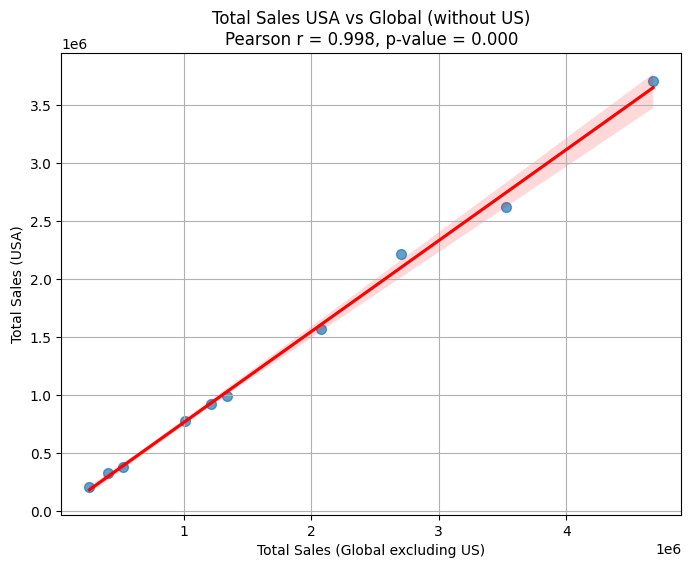

In [ ]:
corr_coef, p_value = pearsonr(compare_df['total_sales_global_no_us'], compare_df['total_sales_usa'])

plt.figure(figsize=(8,6))
sns.regplot(
    x='total_sales_global_no_us',
    y='total_sales_usa',
    data=compare_df,
    scatter_kws={'s':50, 'alpha':0.7},
    line_kws={'color':'red'}
)
plt.xlabel('Total Sales (Global excluding US)')
plt.ylabel('Total Sales (USA)')
plt.title(f'Total Sales USA vs Global (without US)\nPearson r = {corr_coef:.3f}, p-value = {p_value:.3f}')
plt.grid(True)
plt.show()

The correlation coefficient between the compared sales metrics is 0.998, indicating an almost perfect positive relationship. This means that total sales in the USA and global sales excluding the USA are very similar, showing almost identical trends across product categories.

In [ ]:
total_sales = df['product_price'].sum()

sales_by_device = (
    df[df['product_price'].notnull()]
    .groupby('device', observed=True)['product_price']
    .sum()
    .reset_index()
)
sales_by_device['percent_of_total'] = (sales_by_device['product_price'] / total_sales) * 100
sales_by_device = sales_by_device.sort_values(by='percent_of_total', ascending=False)

sales_by_device

,device,product_price,percent_of_total
0,Desktop,1.886404e+07,59.002239
1,Mobile,1.238423e+07,38.734921
2,Tablet,7.234663e+05,2.262831


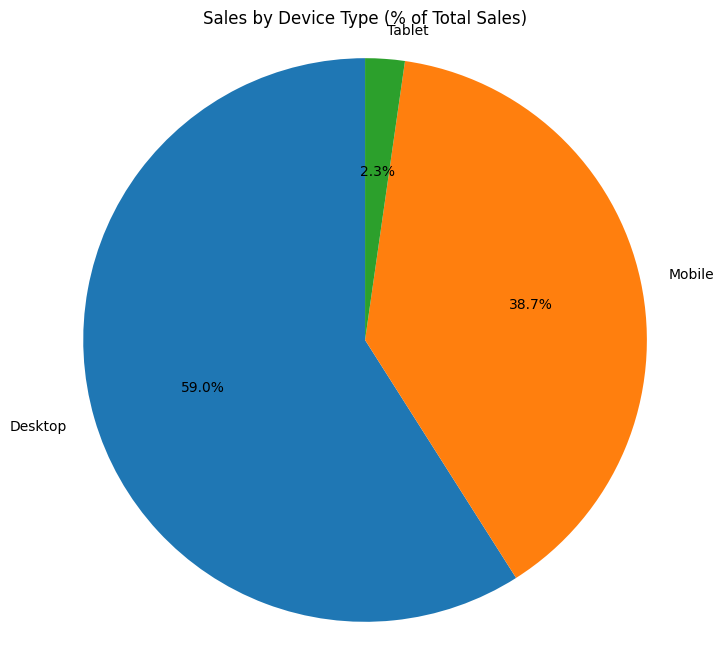

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(
    sales_by_device['percent_of_total'],
    labels=sales_by_device['device'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Sales by Device Type (% of Total Sales)')
plt.axis('equal')
plt.show()

Sales by Device Type

The majority of sales 59% come from Desktop users, followed by Mobile devices contributing 38.7%, and Tablets accounting for only 2.3% of total sales.

In [ ]:
sales_by_model = (
    df[df['product_price'].notnull()]
    .groupby('mobile_model_name', observed=True)['product_price']
    .sum()
    .reset_index()
)
sales_by_model['percent_of_total'] = (sales_by_model['product_price'] / total_sales) * 100
sales_by_model = sales_by_model.sort_values(by='percent_of_total', ascending=False)

sales_by_model

,mobile_model_name,product_price,percent_of_total
0,Chrome,8.899524e+06,27.835598
7,Unspecified,6.535331e+06,20.440964
6,Safari,6.491062e+06,20.302504
9,iPhone,6.420776e+06,20.082666
1,ChromeBook,1.830459e+06,5.725241
2,Edge,6.972223e+05,2.180746
8,iPad,4.488542e+05,1.403909
3,Firefox,4.210669e+05,1.316997
5,Pixel 4 XL,1.182877e+05,0.369976
4,Pixel 3,1.091482e+05,0.341390


The mobile_model_name data is inconsistent—it contains browsers (Chrome, Safari), device models (iPhone, Pixel), and unspecified entries, so it's not purely mobile device models.

In [ ]:
total_sales = df['product_price'].sum()

sales_by_traffic = (
    df[df['product_price'].notnull()]
    .groupby('traffic_channel', observed=True)['product_price']
    .sum()
    .reset_index()
)

sales_by_traffic['percent_of_total'] = (sales_by_traffic['product_price'] / total_sales) * 100
sales_by_traffic = sales_by_traffic.sort_values(by='percent_of_total', ascending=False)

sales_by_traffic

,traffic_channel,product_price,percent_of_total
1,Organic Search,11433152.00,35.760189
2,Paid Search,8511049.00,26.620543
0,Direct,7494923.50,23.442343
3,Social Search,2532105.75,7.919827
4,Unspecified,2000501.00,6.257093


Key traffic channel insights:

Majority of revenue comes from Organic Search (35.8%)

Paid Search and Direct together contribute about half of sales (26.6% + 23.4%)

Smaller shares from Social Search (7.9%) and Unspecified (6.3%) channels

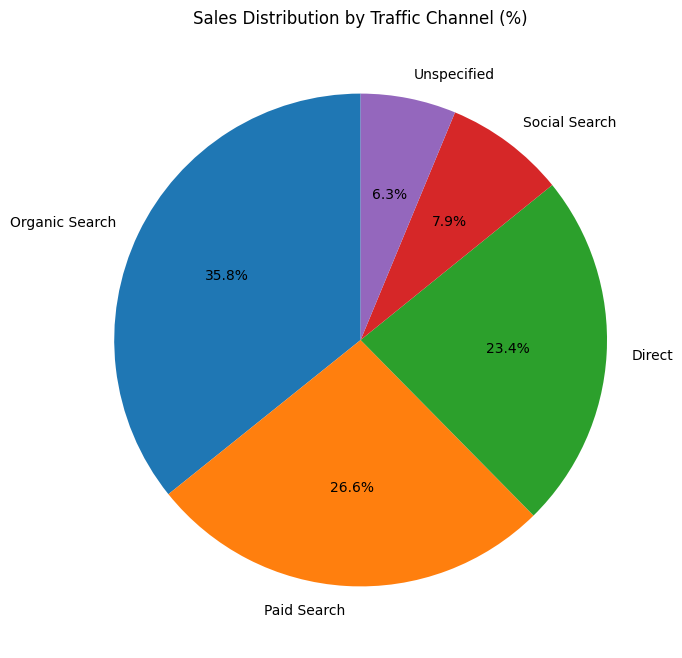

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(
    sales_by_traffic['percent_of_total'],
    labels=sales_by_traffic['traffic_channel'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Sales Distribution by Traffic Channel (%)')
plt.show()

In [ ]:
sales_by_subscription = (
    df[df['product_price'].notnull()]
    .groupby('unsubscribed')['product_price']
    .sum()
    .reset_index()
)

sales_by_subscription

,unsubscribed,product_price
0,False,2.150797e+06
1,True,4.317216e+05


In [ ]:
registered_users_by_country = (
    df[df['account_id'].notnull()]
    .groupby('country', observed=True)['account_id']
    .nunique()
    .reset_index(name='registered_users')
    .sort_values(by='registered_users', ascending=False)
)

registered_users_by_country.head(10)

,country,registered_users
103,United States,12384
42,India,2687
17,Canada,2067
102,United Kingdom,859
32,France,553
91,Spain,536
95,Taiwan,500
19,China,490
34,Germany,490
47,Italy,386


### Date analysis

In [ ]:
daily_stats = (
    df[df['product_price'].notnull()]
    .groupby('order_date')['product_price']
    .agg(['sum', 'mean'])
    .reset_index()
)

daily_stats.head()

,order_date,sum,mean
0,2020-11-01,244292.50000,869.368347
1,2020-11-02,355506.81250,966.051147
2,2020-11-03,498979.59375,889.446716
3,2020-11-04,339187.09375,916.721863
4,2020-11-05,391276.59375,1008.444824


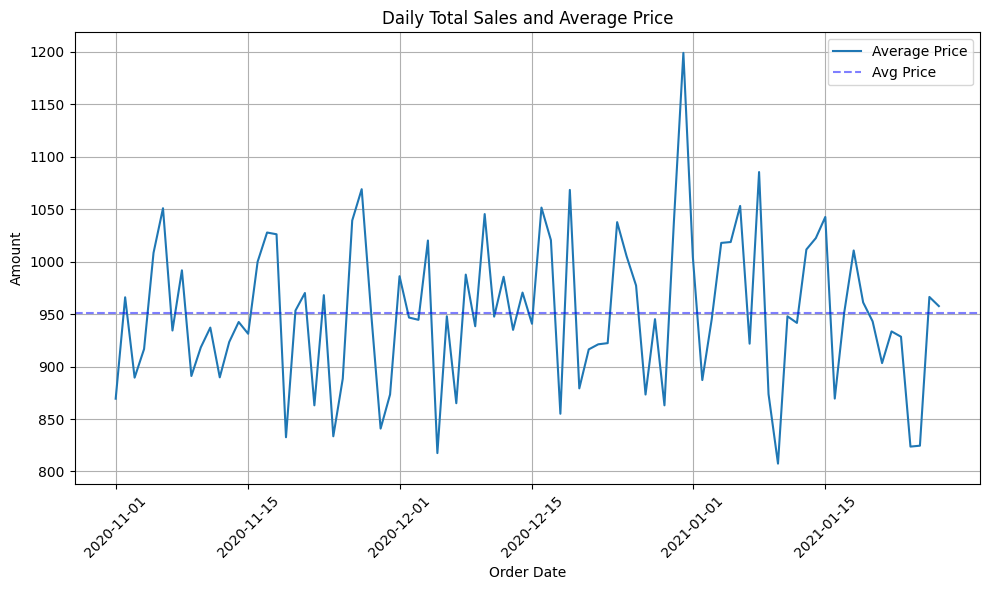

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(daily_stats['order_date'], daily_stats['mean'], label='Average Price')
plt.axhline(daily_stats['mean'].mean(), color='blue', linestyle='--', alpha=0.5, label='Avg Price')
plt.title('Daily Total Sales and Average Price')
plt.xlabel('Order Date')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

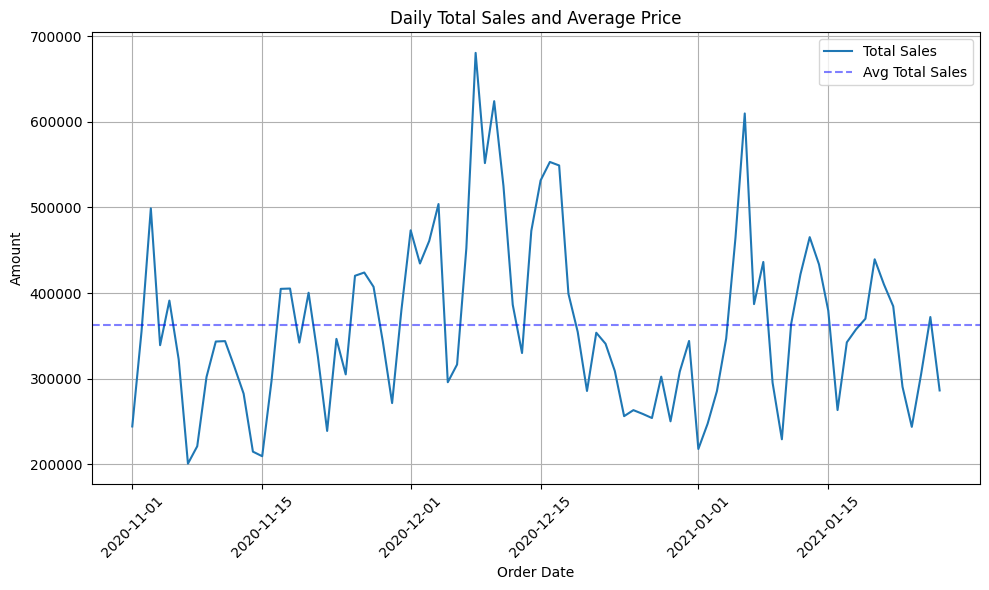

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(daily_stats['order_date'], daily_stats['sum'], label='Total Sales')
plt.axhline(daily_stats['sum'].mean(), color='blue', linestyle='--', alpha=0.5, label='Avg Total Sales')
plt.title('Daily Total Sales and Average Price')
plt.xlabel('Order Date')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
continents = ['Americas', 'Asia', 'Europe']
df_filtered = df[df['continent'].isin(continents) & df['product_price'].notnull()]

daily_continent_sales = (
    df_filtered.groupby(['order_date', 'continent'], observed=False)['product_price']
    .sum()
    .reset_index()
)

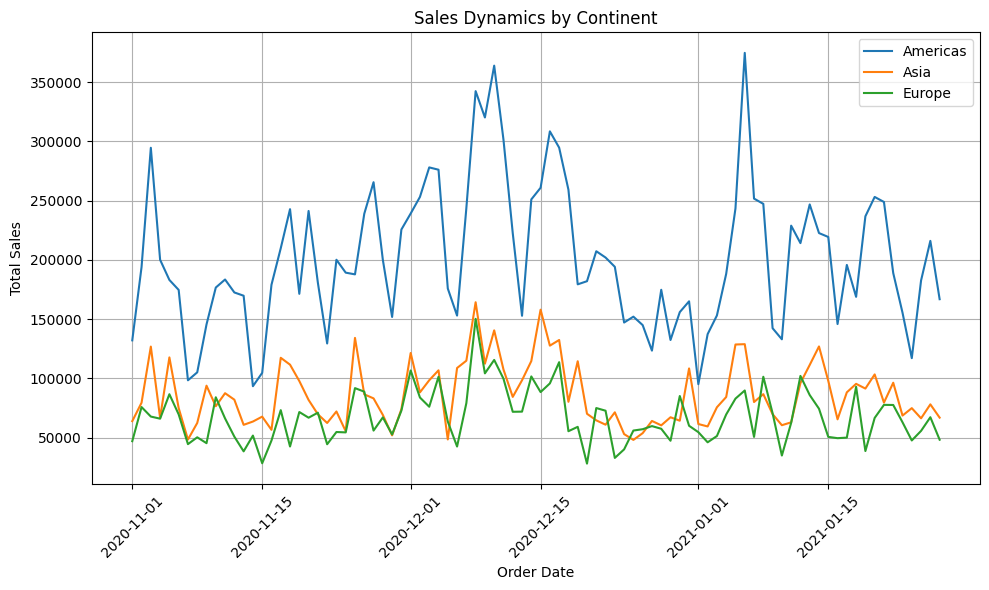

In [ ]:
plt.figure(figsize=(10,6))
for continent in continents:
    data = daily_continent_sales[daily_continent_sales['continent'] == continent]
    plt.plot(data['order_date'], data['product_price'], label=continent)

plt.title('Sales Dynamics by Continent')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_device_filtered = df[df['product_price'].notnull()]

daily_device_sales = (
    df_device_filtered.groupby(['order_date', 'device'], observed=True)['product_price']
    .sum()
    .reset_index()
)

devices = daily_device_sales['device'].unique()

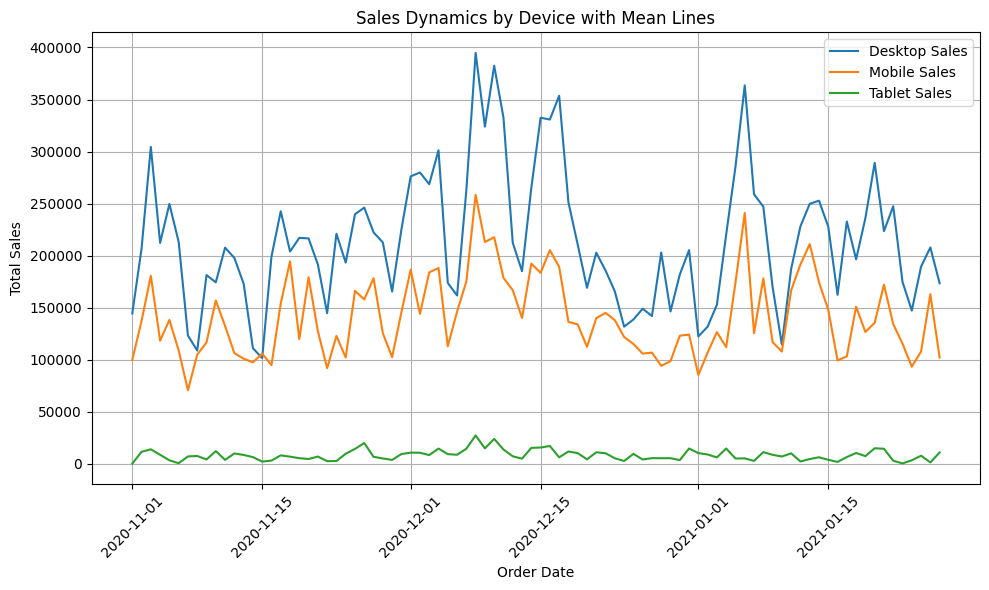

In [ ]:
plt.figure(figsize=(10,6))

for device in devices:
    data = daily_device_sales[daily_device_sales['device'] == device]
    plt.plot(data['order_date'], data['product_price'], label=f'{device} Sales')

plt.title('Sales Dynamics by Device with Mean Lines')
plt.xlabel('Order Date')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Overall, the trend shows clear seasonality, with a similar weekly pattern observed across all charts.

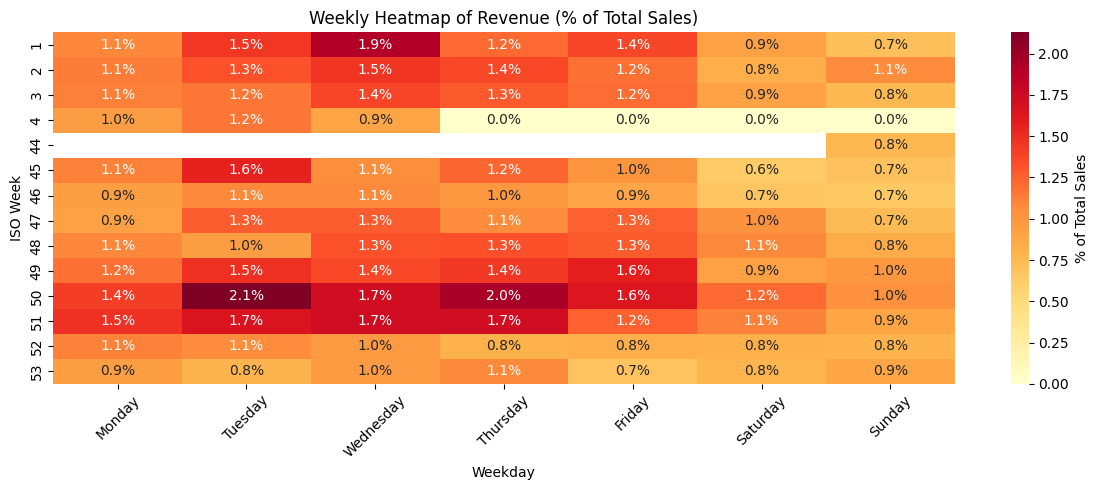

In [ ]:
df['weekday'] = df['order_date'].dt.day_name()
df['week'] = df['order_date'].dt.isocalendar().week
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

total_sales = df['product_price'].sum()

heatmap_data = (
    df.groupby(['week', 'weekday'])['product_price']
    .sum()
    .unstack()
    .reindex(columns=weekday_order)
)

heatmap_percent = (heatmap_data / total_sales) * 100
annot_labels = heatmap_percent.map(lambda x: f'{x:.1f}%' if pd.notnull(x) else '')

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_percent, cmap='YlOrRd', annot=annot_labels, fmt='', cbar_kws={'label': '% of Total Sales'})
plt.title("Weekly Heatmap of Revenue (% of Total Sales)")
plt.xlabel("Weekday")
plt.ylabel("ISO Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The Weekly Heatmap of Revenue (% of Total Sales) clearly shows that Tuesday, Wednesday, and Thursday generate the highest revenue, followed by Friday and Monday, with Saturday and Sunday having the lowest sales.

In [ ]:
orders = df[df['product_price'] > 0].copy()
orders['order_week'] = orders['order_date'].dt.to_period('W').apply(lambda x: x.start_time)

heat_data = orders.groupby(['order_week', 'product_category'], observed=False).agg(
    revenue=('product_price', 'sum')
).reset_index()

In [ ]:
pivot_table = heat_data.pivot(index='product_category', columns='order_week', values='revenue').fillna(0)
category_order = pivot_table.sum(axis=1).sort_values(ascending=False).index
pivot_sorted = pivot_table.loc[category_order]
pivot_sorted.columns = [col.strftime('%Y-%m-%d') for col in pivot_sorted.columns]

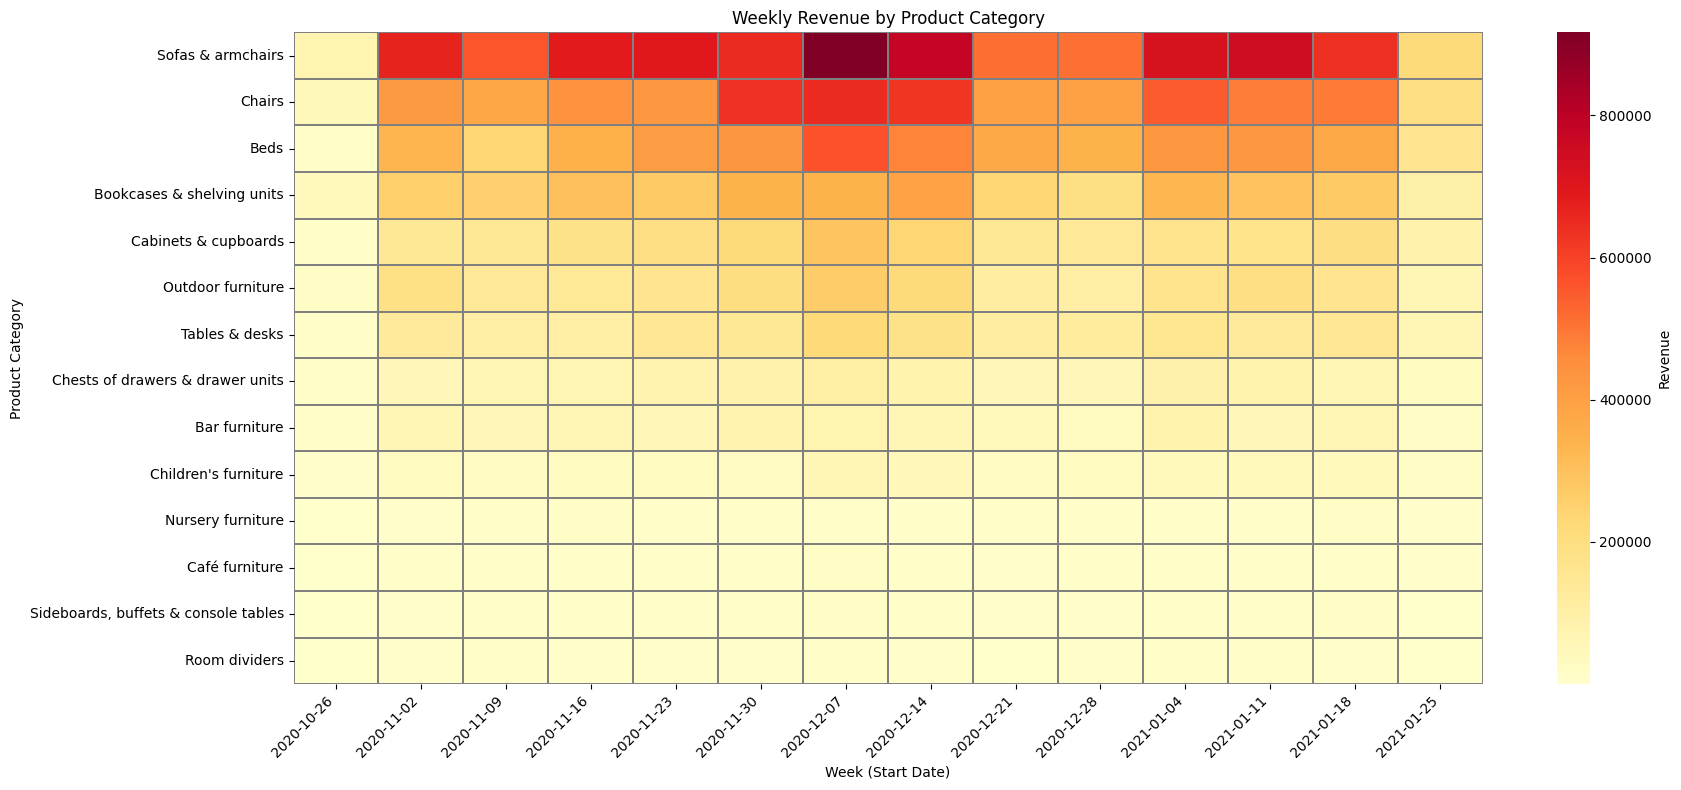

In [ ]:
plt.figure(figsize=(18, 8))
sns.heatmap(
    pivot_sorted,
    cmap='YlOrRd',
    linewidths=0.1,
    linecolor='gray',
    cbar_kws={'label': 'Revenue'}
)

plt.title('Weekly Revenue by Product Category')
plt.xlabel('Week (Start Date)')
plt.ylabel('Product Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Weekly revenue clearly highlights Sofas & Armchairs as a top-performing category with consistently strong results. Following closely are Chairs and Beds, which are also similar product categories to ours. This pattern suggests steady demand in these furniture segments over time.

### Pivot Tables

In [ ]:
pivot_table = pd.pivot_table(
    df,
    values="product_price",
    index="traffic_channel",
    columns="device",
    aggfunc="sum",
    observed=True
)

pivot_table

device,Desktop,Mobile,Tablet
traffic_channel,,,
Direct,4472609.50,2.875318e+06,146996.093750
Organic Search,6794108.00,4.408875e+06,230168.703125
Paid Search,4976978.00,3.330032e+06,204039.000000
Social Search,1447384.75,1.006707e+06,78013.601562
Unspecified,1172959.25,7.632929e+05,64248.898438


 Desktop consistently drives the highest revenue across all channels, followed by Mobile, with Tablet contributing the least.

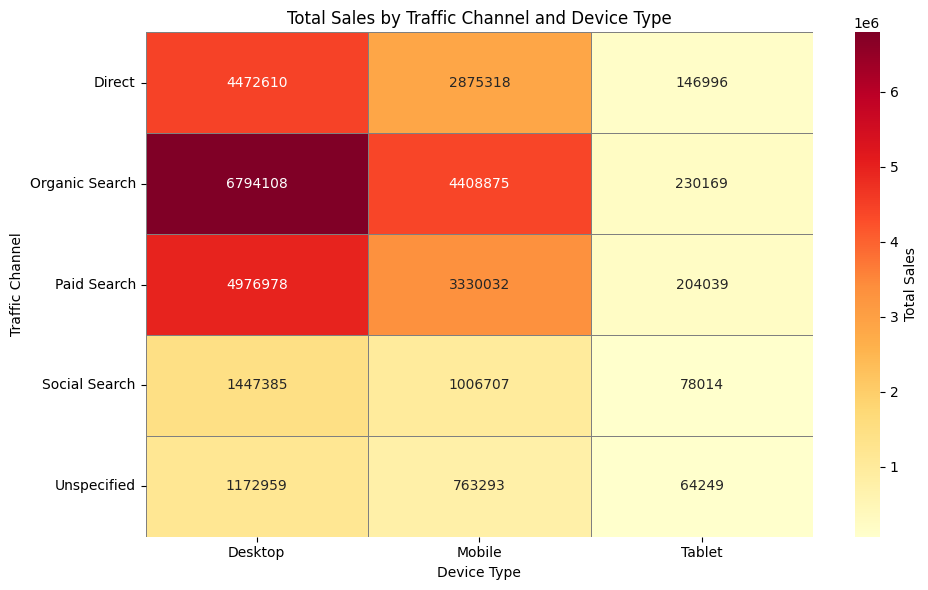

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap="YlOrRd", annot=True, fmt=".0f", linewidths=0.5, linecolor="gray", cbar_kws={'label': 'Total Sales'})

plt.title("Total Sales by Traffic Channel and Device Type")
plt.xlabel("Device Type")
plt.ylabel("Traffic Channel")
plt.tight_layout()
plt.show()

In [ ]:
pivot_sessions = pd.pivot_table(
    df,
    index='traffic_channel',
    columns='device',
    values='ga_session_id',
    aggfunc='count',
    observed=True
)

pivot_sessions

device,Desktop,Mobile,Tablet
traffic_channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638
Unspecified,12527,8486,470


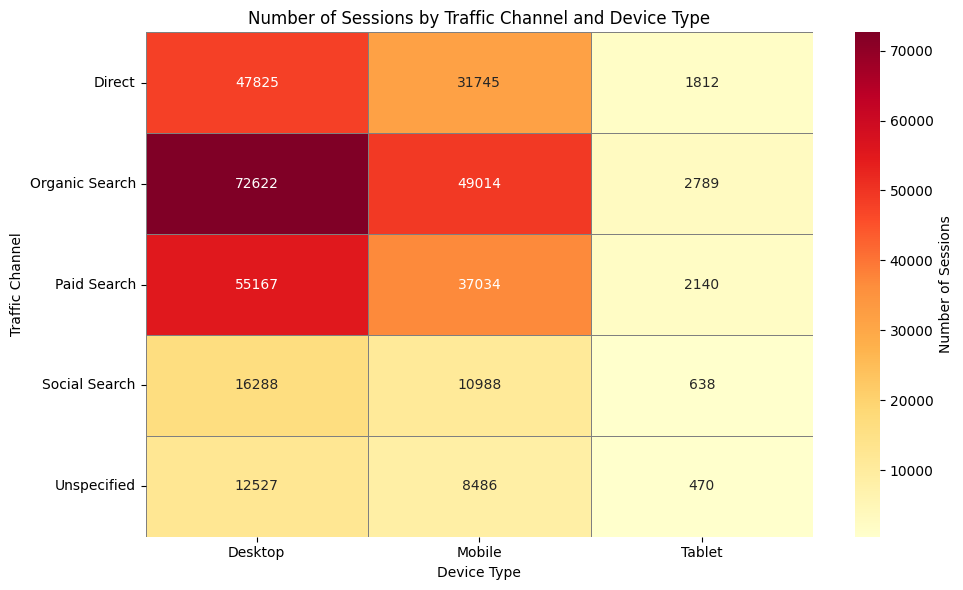

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_sessions,
    cmap="YlOrRd",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={'label': 'Number of Sessions'}
)

plt.title("Number of Sessions by Traffic Channel and Device Type")
plt.xlabel("Device Type")
plt.ylabel("Traffic Channel")
plt.tight_layout()
plt.show()

Organic Search generates the highest revenue and sessions overall, followed by Paid Search, and then Direct traffic.



In [ ]:
pivot_table = pd.pivot_table(
    df,
    values="product_price",
    index="product_category",
    columns="country",
    aggfunc="sum",
    observed=False
)

top_categories = pivot_table.sum(axis=1).nlargest(10).index
top_countries = pivot_table.loc[top_categories].sum(axis=0).nlargest(5).index

pivot_table = pivot_table.loc[top_categories, top_countries]

pivot_table

country,United States,India,Canada,United Kingdom,France
product_category,,,,,
Sofas & armchairs,3.707144e+06,788430.00000,692427.500000,234812.000000,187735.000000
Chairs,2.619774e+06,544309.18750,417740.812500,188519.406250,134029.406250
Beds,2.213058e+06,358319.50000,354772.000000,133816.000000,116414.000000
Bookcases & shelving units,1.567607e+06,364507.40625,278981.906250,113987.601562,73830.000000
Cabinets & cupboards,9.945455e+05,191888.00000,181802.000000,71684.500000,59101.500000
Outdoor furniture,9.292452e+05,162289.40625,185322.796875,57002.398438,40486.398438
Tables & desks,7.778650e+05,186157.50000,132678.000000,49374.000000,42299.000000
Chests of drawers & drawer units,3.823880e+05,73111.00000,71952.000000,36784.000000,21544.500000
Bar furniture,3.308050e+05,57657.00000,51724.000000,22103.000000,11199.000000


### ABC analysis

In [ ]:
df['month'] = df['order_date'].dt.to_period('M')

df_filtered = df[['month', 'product_category', 'product_price']].dropna()

monthly_sales = df_filtered.groupby(['month', 'product_category'], observed=True)['product_price'].sum().reset_index()

def abc_classify_group(group):
    group = group.copy()
    group = group.sort_values(by='product_price', ascending=False)
    group['cum_sum'] = group['product_price'].cumsum()
    group['cum_perc'] = 100 * group['cum_sum'] / group['product_price'].sum()
    group['ABC'] = group['cum_perc'].apply(lambda x: 'A' if x <= 80 else ('B' if x <= 95 else 'C'))
    return group.drop(columns=['cum_sum', 'cum_perc'])

monthly_abc = (
    monthly_sales.groupby('month', group_keys=False)
    .apply(lambda x: abc_classify_group(x))
    .reset_index(drop=True)
)

monthly_abc.head()

<ipython-input-365-2fb957caea62>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: abc_classify_group(x))


,month,product_category,product_price,ABC
0,2020-11,Sofas & armchairs,2773289.00,A
1,2020-11,Chairs,1804219.75,A
2,2020-11,Beds,1396037.00,A
3,2020-11,Bookcases & shelving units,1178001.25,A
4,2020-11,Cabinets & cupboards,707734.50,A


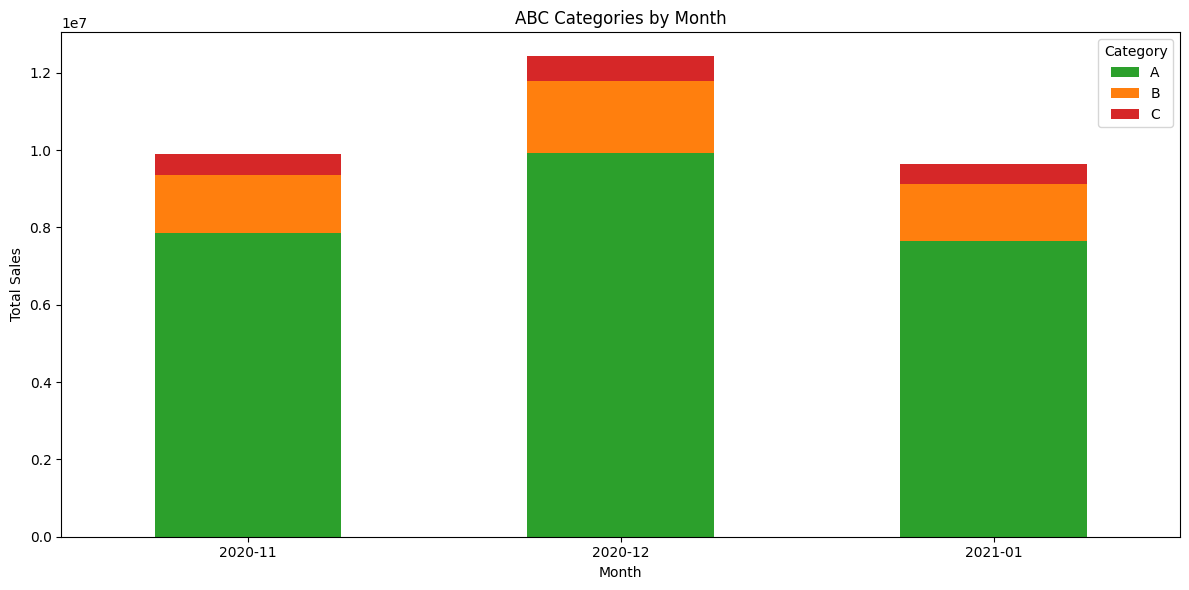

In [ ]:
abc_summary = monthly_abc.groupby(['month', 'ABC'])['product_price'].sum().reset_index()
abc_pivot = abc_summary.pivot(index='month', columns='ABC', values='product_price').fillna(0)

abc_pivot.plot(kind='bar', stacked=True, figsize=(12,6), color={'A':'#2ca02c','B':'#ff7f0e','C':'#d62728'})
plt.title('ABC Categories by Month')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.xticks(rotation=0)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

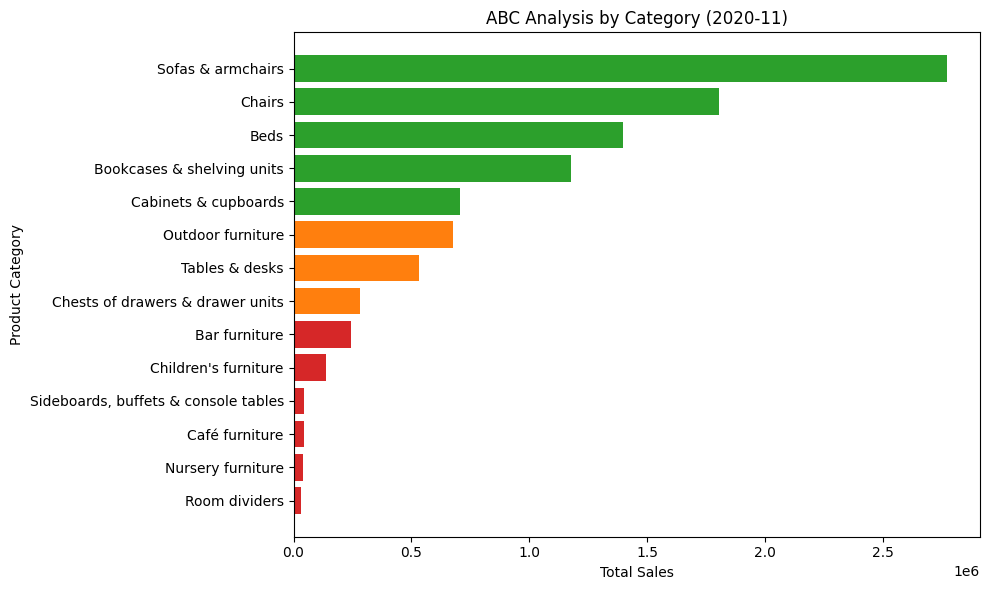

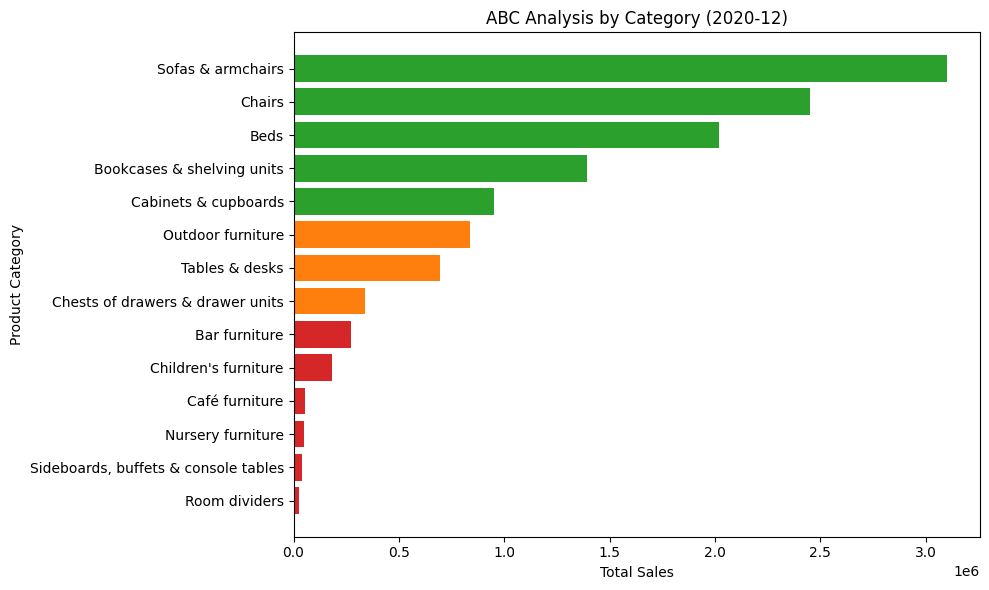

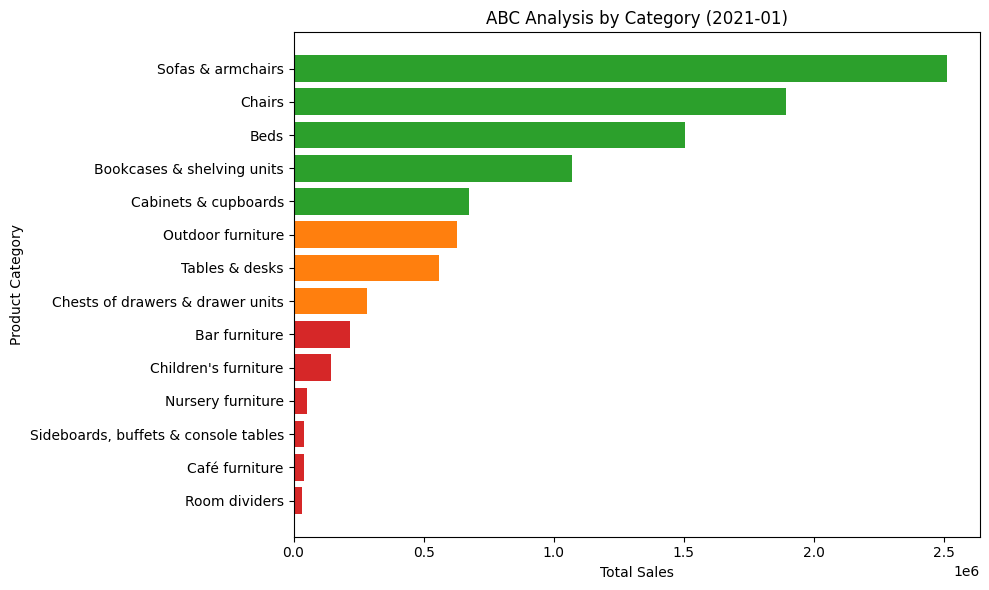

In [ ]:
abc_colors = {'A': '#2ca02c', 'B': '#ff7f0e', 'C': '#d62728'}

months = monthly_abc['month'].unique()

for month in months:
    data = monthly_abc[monthly_abc['month'] == month].sort_values('product_price')

    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        data['product_category'],
        data['product_price'],
        color=data['ABC'].map(abc_colors)
    )

    plt.title(f'ABC Analysis by Category ({month})')
    plt.xlabel('Total Sales')
    plt.ylabel('Product Category')
    plt.tight_layout()
    plt.show()

The five categories — Sofas & Armchairs, Chairs, Beds, Bookcases & Shelving Units, and Cabinets & Cupboards — consistently generate around 80% of monthly revenue, demonstrating stable performance over time.

### Segmentation

In [ ]:
df_seg = df.copy()

df_seg['is_registered'] = df_seg['account_id'].notna()
df_seg['is_subscribed'] = df_seg['unsubscribed'].fillna(False) == False

df_price = df_seg[df_seg['product_price'].notna()].copy()

quantiles = df_price['product_price'].quantile([0.33, 0.66])
low_cutoff = quantiles.loc[0.33]
high_cutoff = quantiles.loc[0.66]

def price_segment(price):
    if price <= low_cutoff:
        return 'Low'
    elif price <= high_cutoff:
        return 'Medium'
    else:
        return 'High'

df_price['price_segment'] = df_price['product_price'].apply(price_segment)

grouped = df_price.groupby(['is_registered', 'is_subscribed', 'price_segment']).agg(
    users=('account_id', 'nunique'),
    orders=('product_price', 'count'),
    total_revenue=('product_price', 'sum'),
    avg_check=('product_price', 'mean')
).reset_index()

grouped['is_registered'] = grouped['is_registered'].map({True: 'Yes', False: 'No'})
grouped['is_subscribed'] = grouped['is_subscribed'].map({True: 'Yes', False: 'No'})

grouped.sort_values(by='orders', ascending=False)

,is_registered,is_subscribed,price_segment,users,orders,total_revenue,avg_check
0,No,Yes,High,0,10459,2.356812e+07,2253.381592
2,No,Yes,Medium,0,10188,4.763938e+06,467.602875
1,No,Yes,Low,0,10110,1.057157e+06,104.565468
7,Yes,Yes,Low,826,826,8.575840e+04,103.823730
6,Yes,Yes,High,764,764,1.723918e+06,2256.437500
8,Yes,Yes,Medium,744,744,3.411203e+05,458.495056
3,Yes,No,High,160,160,3.514770e+05,2196.731201
4,Yes,No,Low,144,144,1.474460e+04,102.393051
5,Yes,No,Medium,143,143,6.550000e+04,458.041962


Most revenue comes from unregistered but subscribed users, especially in the High price segment, with a high average order value around $2,250.

Registered and subscribed users have fewer orders but similar average order values in the High segment.

Registered but unsubscribed users contribute the least but still show relatively high average checks in the High segment.

It is likely that users need to subscribe or register to place an order. Encouraging registration is important to better track and understand user behavior for more detailed insights and personalized marketing.

In [ ]:
df_price = df[df['product_price'].notna()].copy()

price_mean = df_price['product_price'].mean()
price_std = df_price['product_price'].std()
price_min = df_price['product_price'].min()
price_max = df_price['product_price'].max()

def price_segment(price):
    if price <= price_mean:
        return 'Low'
    elif price <= price_mean + price_std:
        return 'Low-Medium'
    elif price <= price_mean + 2*price_std:
        return 'Medium-High'
    else:
        return 'High'


df_price['price_segment'] = df_price['product_price'].apply(price_segment)

grouped = df_price.groupby('price_segment').agg(
    users=('account_id', 'nunique'),
    orders=('product_price', 'count'),
    total_revenue=('product_price', 'sum'),
    avg_check=('product_price', 'mean')
).reset_index()

grouped = grouped.sort_values(by='orders', ascending=False)
grouped

,price_segment,users,orders,total_revenue,avg_check
1,Low,1947,23267,7321874.0,314.689209
2,Low-Medium,533,6388,9241555.0,1446.705566
3,Medium-High,145,2003,5562013.5,2776.841553
0,High,156,1880,9846288.0,5237.387207


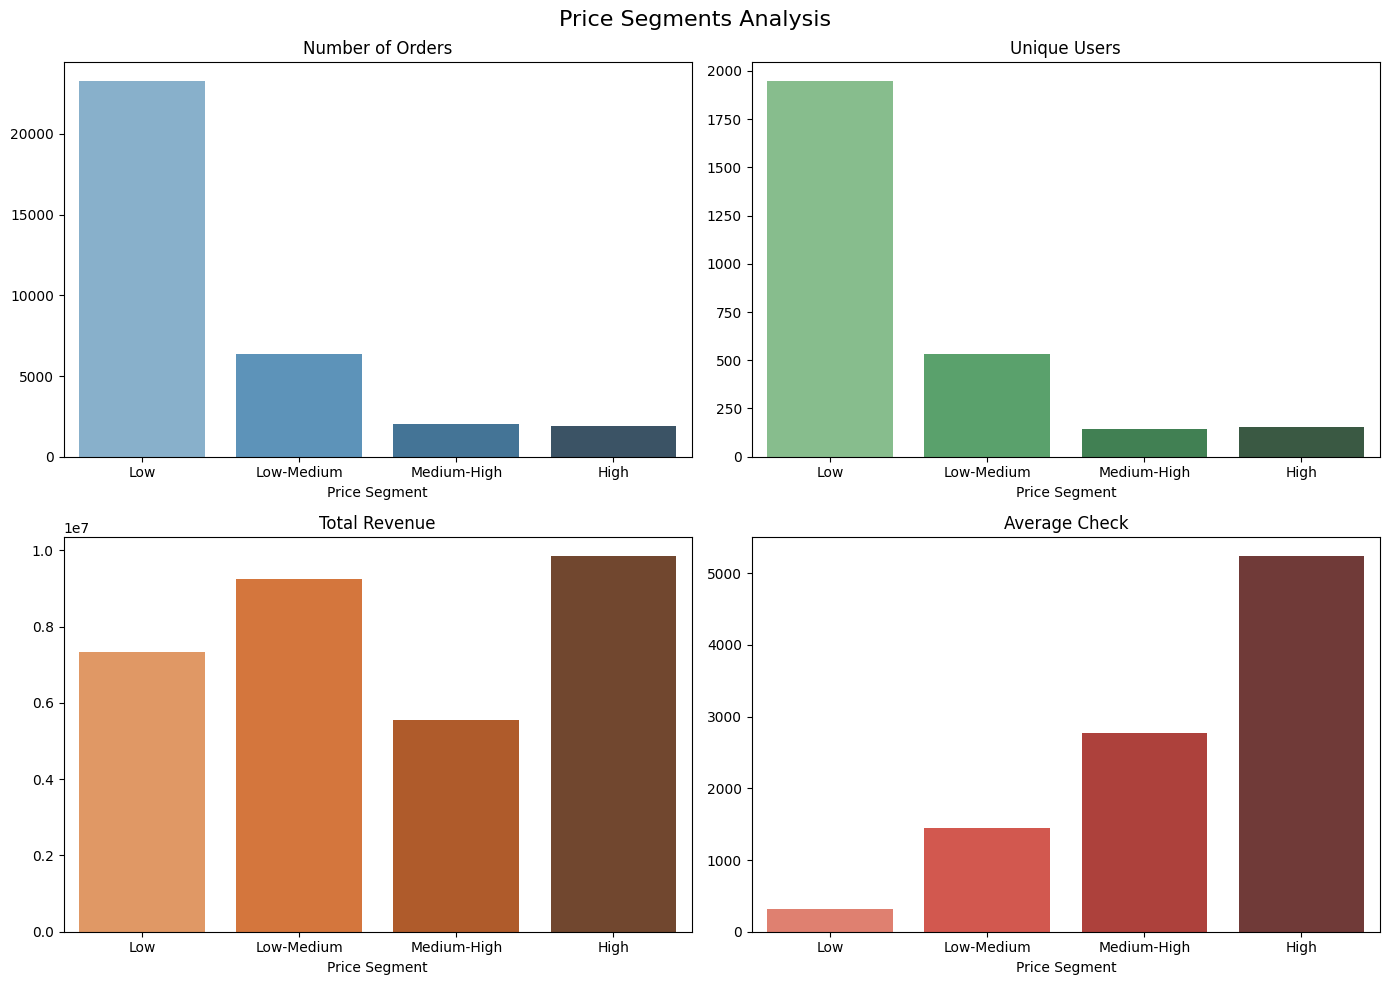

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Price Segments Analysis', fontsize=16)

sns.barplot(x='price_segment', y='orders', data=grouped, ax=axes[0, 0], hue='price_segment', palette='Blues_d', legend=False)
axes[0, 0].set_title('Number of Orders')

sns.barplot(x='price_segment', y='users', data=grouped, ax=axes[0, 1], hue='price_segment', palette='Greens_d', legend=False)
axes[0, 1].set_title('Unique Users')

sns.barplot(x='price_segment', y='total_revenue', data=grouped, ax=axes[1, 0], hue='price_segment', palette='Oranges_d', legend=False)
axes[1, 0].set_title('Total Revenue')

sns.barplot(x='price_segment', y='avg_check', data=grouped, ax=axes[1, 1], hue='price_segment', palette='Reds_d', legend=False)
axes[1, 1].set_title('Average Check')

for ax in axes.flat:
    ax.set_xlabel('Price Segment')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

This highlights a clear trend: as the price segment increases, the average order value rises significantly, even though the number of users and orders decreases.

### Statistics part

In [ ]:
pivot_table = (
    df[df['order_date'].notna() & df['ga_session_id'].notna() & df['product_price'].notna()]
    .groupby('order_date')
    .agg(
        sessions=('ga_session_id', 'count'),
        revenue=('product_price', 'sum')
    )
    .reset_index()
)

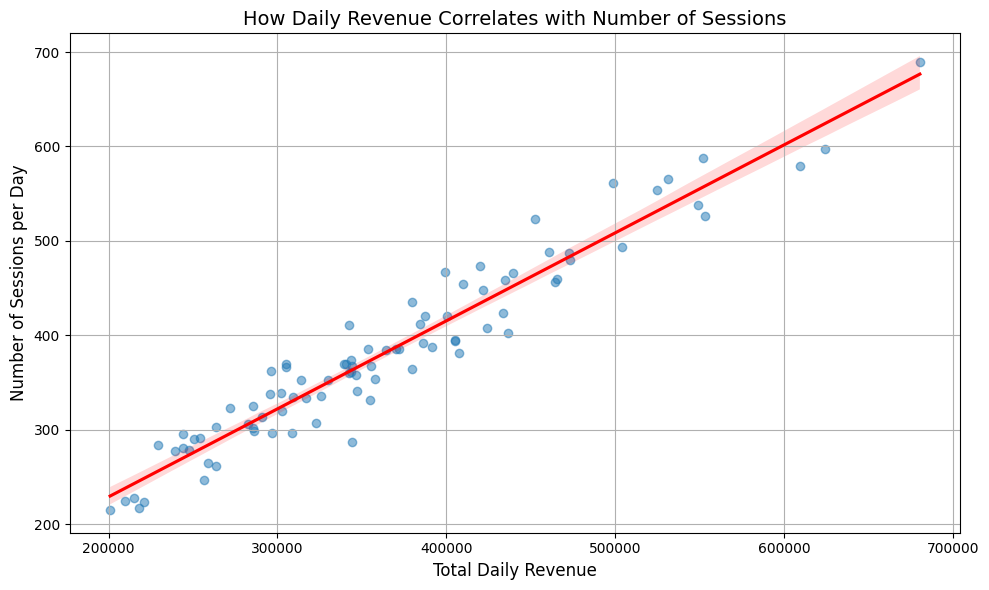

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=pivot_table,
    x="revenue",
    y="sessions",
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.xlabel("Total Daily Revenue", fontsize=12)
plt.ylabel("Number of Sessions per Day", fontsize=12)
plt.title("How Daily Revenue Correlates with Number of Sessions", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
corr_coef, p_value = pearsonr(pivot_table['revenue'], pivot_table['sessions'])

print(f"[revenue-sessions] Pearson correlation: {corr_coef:.3f}")
print(f"[revenue-sessions] p-value: {p_value:.3f}")

[revenue-sessions] Pearson correlation: 0.964
[revenue-sessions] p-value: 0.000


It means that as the number of sessions increases, revenue tends to increase proportionally.

In [ ]:
df['continent'] = df['continent'].str.strip().str.capitalize()
df_sales = df[df['product_price'].notna() & (df['continent'] != 'Unspecified')].copy()

sales_by_date = (
    df_sales.groupby(['order_date', 'continent'], observed=False)['product_price']
    .sum()
    .reset_index()
)

sales_pivot = sales_by_date.pivot(index='order_date', columns='continent', values='product_price')

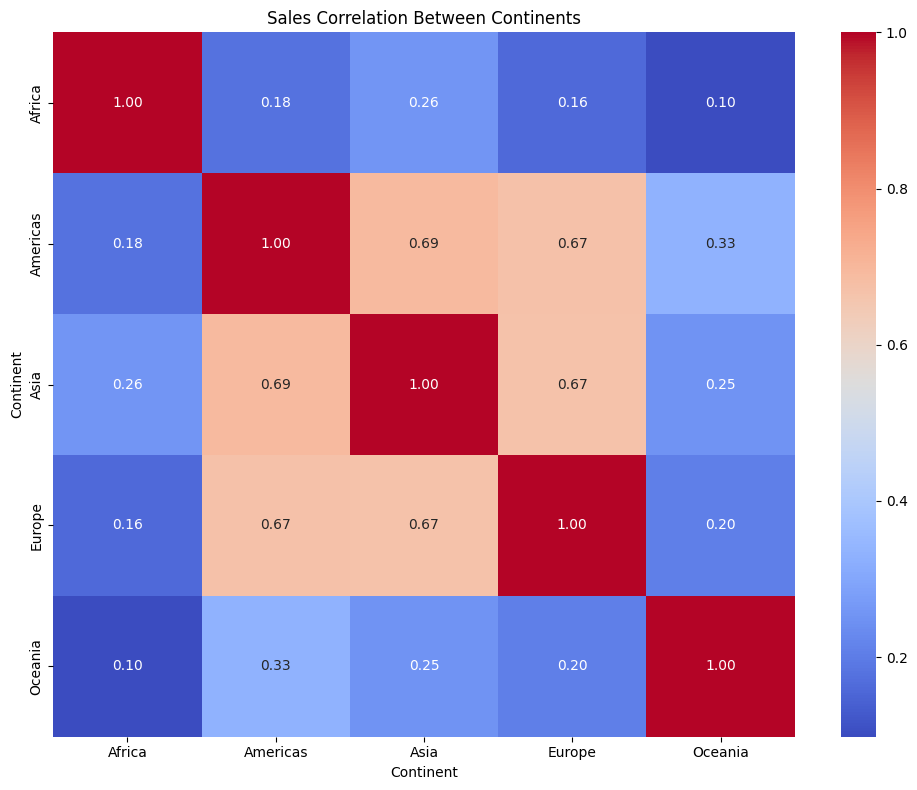

In [ ]:
plt.figure(figsize=(10, 8))
corr_matrix = sales_pivot.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Sales Correlation Between Continents')
plt.xlabel('Continent')
plt.ylabel('Continent')
plt.tight_layout()
plt.show()

The highest correlation is between the Americas and Asia (0.69), followed closely by Europe and Asia (0.67), and Americas and Europe (0.67). This indicates similar sales trends across these regions.

In [ ]:
sales_by_channel = (
    df[df['product_price'].notna()]
    .groupby(['order_date', 'traffic_channel'], observed=False)['product_price']
    .sum()
    .unstack(fill_value=0)
)

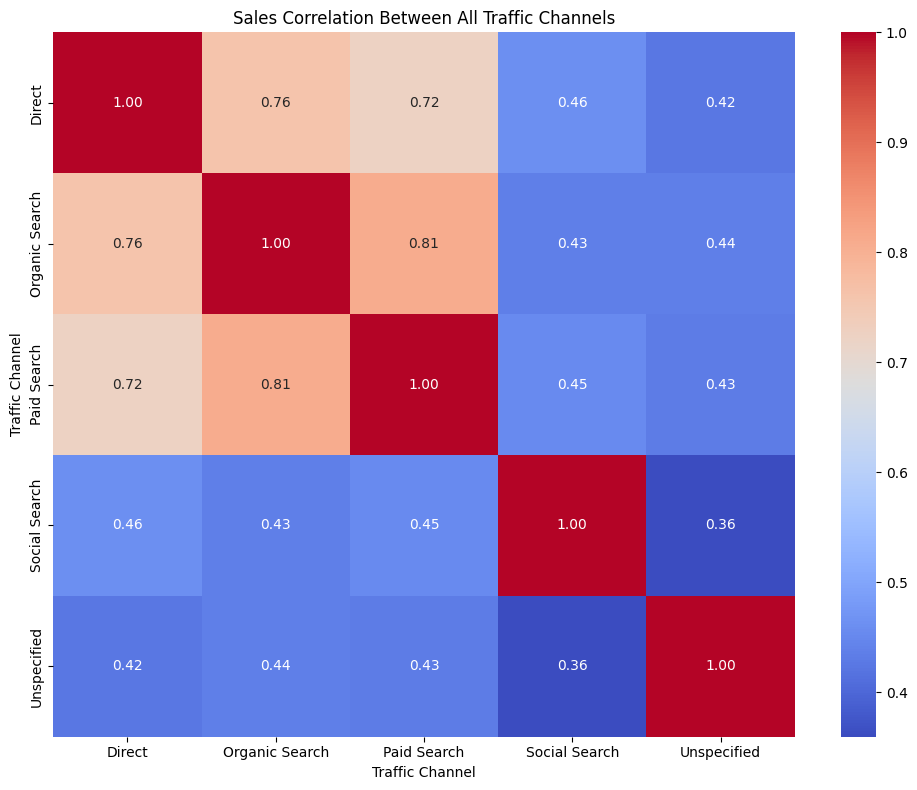

In [ ]:
plt.figure(figsize=(10, 8))
corr_matrix = sales_by_channel.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Sales Correlation Between All Traffic Channels')
plt.xlabel('Traffic Channel')
plt.ylabel('Traffic Channel')
plt.tight_layout()
plt.show()

This shows strong positive correlations between sales from Organic Search, Direct and Paid Search traffic channels.

In [ ]:
sales_by_category = (
    df[df['product_price'].notna()]
    .groupby(['order_date', 'product_category'], observed=False)['product_price']
    .sum()
    .unstack(fill_value=0)
)

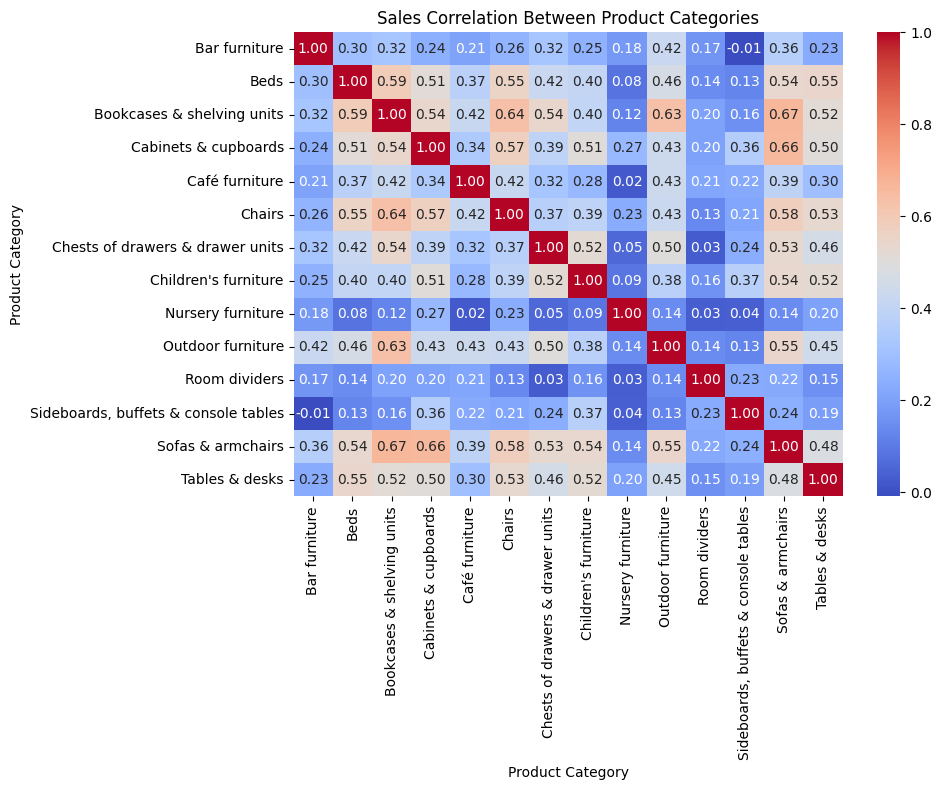

In [ ]:
plt.figure(figsize=(10, 8))
corr_matrix = sales_by_category.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Sales Correlation Between Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

Sales of living and bedroom staples (Sofas, Beds, Bookcases, Cabinets, Chairs, Tables) show moderate to strong positive correlations, while Nursery Furniture and Room Dividers sales behave independently; no significant negative sales correlations are observed.

## Visualization

---



https://app.powerbi.com/links/7FVz_a5pQc?ctid=2ca41f62-9f62-4c01-b1f6-b033d2603a9d&pbi_source=linkShare

Which is better?

https://app.powerbi.com/links/sKeLsMGIc4?ctid=2ca41f62-9f62-4c01-b1f6-b033d2603a9d&pbi_source=linkShare

## Summary

---



Sales are driven mainly by the US, Asia, and Europe, with top categories like Sofas, Chairs, Beds, Bookcases, and Cabinets generating about 80% of monthly revenue consistently. Desktop users spend the most per order. Organic Search leads in revenue and sessions, followed by Paid Search and Direct traffic.

Sales peak on weekdays (Tuesday–Thursday) and seasonally in November–December. Registered and subscribed users don’t have much higher order values, but encouraging sign-ups is important for tracking individual customers and offering personalized promotions.

Strong positive correlation exists between sessions and revenue, showing that more quality traffic boosts sales. Focusing on key regions, devices, and high-value users offers the best path for growth.